In [2]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import csv
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import scipy
from sklearn import random_projection
from cluster_func import em
from cluster_func import kmeans

In [3]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X = data.data
# clean out '?' values
X = np.nan_to_num(X)
y = data.target

X_f = data.data
y_f = data.target

#Splitting data into training and testing and keeping testing data aside
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

Starting ICA
Dimensionality reduction


/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tole

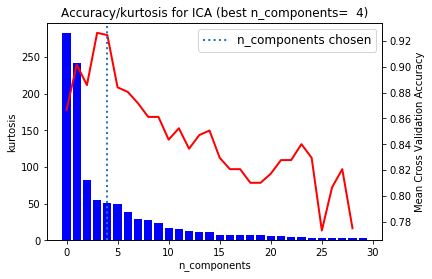

In [5]:
print("Starting ICA")
print("Dimensionality reduction")

def _calculate(X, ica_, n_components):
    
    components = ica_.components_
    ica_.components_ = components[:n_components]

    transformed = ica_.transform(X)
    ica_.components_ = components
 
    kurtosis = scipy.stats.kurtosis(transformed)

    return sorted(kurtosis, reverse = True)	



decisiontree = DecisionTreeClassifier(criterion = 'gini', max_depth = 15, min_samples_split = 5)
ica = FastICA()

pipe = Pipeline(steps=[('ica', ica), ('decisionTree', decisiontree)])

# Plot the ICA spectrum
ica.fit(X)

fig, ax = plt.subplots()
#ax.bar(list(range(1,X.shape[1])), _calculate(X,ica, X.shape[1]) , linewidth=2, color = 'blue')
ax.bar(np.arange(X.shape[1]), _calculate(X,ica, X.shape[1]) , linewidth=2, color = 'blue')

plt.axis('tight')
plt.xlabel('n_components')
ax.set_ylabel('kurtosis')

#Checking the accuracy for taking all combination of components
n_components = range(1, X.shape[1])
# Parameters of pipelines can be set using ‘__’ separated parameter names:
gridSearch = GridSearchCV(pipe, dict(ica__n_components=n_components), cv = 3)
gridSearch.fit(X, y)
results = gridSearch.cv_results_
ax1 = ax.twinx()

#Plotting the accuracies and best component
ax1.plot(results['mean_test_score'], linewidth = 2, color = 'red')
ax1.set_ylabel('Mean Cross Validation Accuracy')
ax1.axvline(gridSearch.best_estimator_.named_steps['ica'].n_components, linestyle=':', label='n_components chosen', linewidth = 2)

plt.legend(prop=dict(size=12))
plt.title('Accuracy/kurtosis for ICA (best n_components=  %d)'%gridSearch.best_estimator_.named_steps['ica'].n_components )
plt.show()


#Reducing the dimensions with optimal number of components
ica_new = FastICA(n_components = gridSearch.best_estimator_.named_steps['ica'].n_components)
ica_new.fit(X_train)
X_train_transformed = ica_new.transform(X_train)
X_test_transformed = ica_new.transform(X_test)


Calculating Reconstruction Error


/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


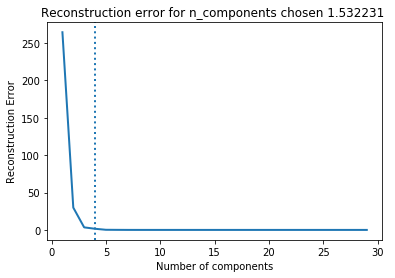

In [6]:
###############################################################################################################################
#Reconstruction Error

print("Calculating Reconstruction Error")


reconstruction_error = []
for comp in n_components:

	ica = FastICA(n_components = comp)
	X_transformed = ica.fit_transform(X_train)
	X_projected = ica.inverse_transform(X_transformed)
	reconstruction_error.append(((X_train - X_projected) ** 2).mean())

	if(comp == gridSearch.best_estimator_.named_steps['ica'].n_components):
		chosen_error = ((X_train - X_projected) ** 2).mean()

fig2,ax2 = plt.subplots()
ax2.plot(n_components, reconstruction_error, linewidth= 2)
ax2.axvline(gridSearch.best_estimator_.named_steps['ica'].n_components, linestyle=':', label='n_components chosen', linewidth = 2)
plt.axis('tight')
plt.xlabel('Number of components')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction error for n_components chosen %f '%chosen_error)
plt.show()

Clustering ICA
Expected Maximization
Training accuracy for Expected Maximization for K = 2:  85.05494505494505
Testing accuracy for Expected Maximization for K = 2:  86.8421052631579
KMeans


/anaconda3/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


Training accuracy for KMeans for K = 2:  58.02197802197803
Testing accuracy for KMeans for K = 2:  62.28070175438597


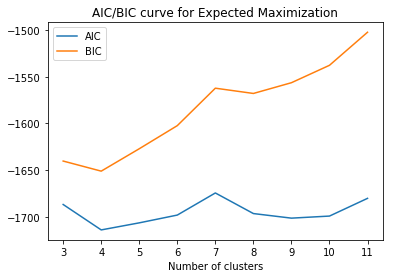

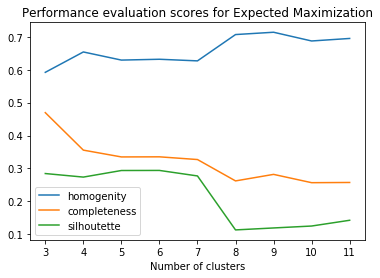

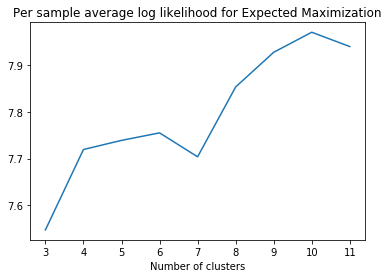

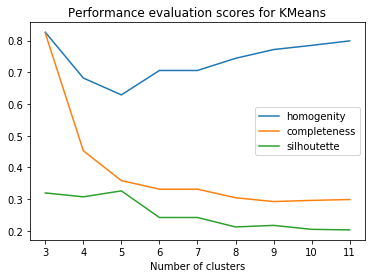

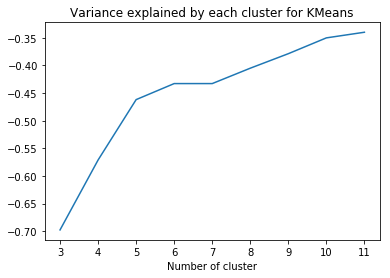

In [7]:
################################################################################################################################
#Dimensionally reduce the full dataset
#Reducing the dimensions with optimal number of components
ica_new = FastICA(n_components = gridSearch.best_estimator_.named_steps['ica'].n_components)
ica_new.fit(X_f)
X_transformed_f = ica_new.transform(X_f)


#Clustering after dimensionality reduction
print("Clustering ICA")


means_init = np.array([X_transformed_f[y_f == i].mean(axis=0) for i in range(2)])

#clustering experiments
print("Expected Maximization")
component_list, array_aic, array_bic, array_homo_1, array_comp_1, array_sil_1, array_avg_log = em(X_train_transformed, X_test_transformed, y_train, y_test, init_means = means_init, component_list = [3,4,5,6,7,8,9,10,11], num_class = 2, toshow =0)

print("KMeans")
component_list, array_homo_2, array_comp_2, array_sil_2, array_var = kmeans(X_train_transformed, X_test_transformed, y_train, y_test, init_means = means_init, component_list = [3,4,5,6,7,8,9,10,11], num_class = 2, toshow = 0)